## Proyecto red neuronal RNN

**Objetivo:** Que el estudiante practique el entrenamiento de una red neuronal tipo RNN (Recursive Neural Network) con la finalidad de entrenar un modelo que permita hacer una predicción en base a datos ordenados de manera secuencial (series temporales)

El proyecto debe tener los siguientes elementos: 

  1.	Selección de datos secuenciales:  Los datos pueden ser seleccionados de un repositorio como kaggle, para ser usados en una red LSTM deben estar ordenados temporalmente (ejemplo:  stock market, temperatura, trafico, frecuencia cardiaca, etc....)

  2.	Procesamiento de datos: Cargar los datos y ordenarlos en bloques temporales para ser utilizados en una red LSTM

  3.	Red neuronal: Definir la arquitectura y los parámetros de una red neuronal LSTM para entrenar el modelo (configuración inicial)

  4.	A partir de los resultados de la configuración inicial y si se observa “overfitting” aplicar el método de “Dropout” 

  5.	Explorar las siguientes variaciones a la red neuronal para investigar si se pueden mejorar los resultados: 

      a.	Variación 1:  Cambiar la configuración de la red neuronal de una LSTM normal a Bidireccional y Stacked 

      b.	Variación 2:  Una variación del optimizer 

      c.	Variación 3: Cambiar el batch_size (ejemplo de 32 a 64)
      

  6.	presentación de resultados: Se deben de presentar los gráficos obtenidos para la configuración inicial y para cada variación propuesta, comparación de la secuencia temporal con el modelo entrenado

  7.	Conclusiones:  En base a los resultados discutir si fue exitoso el entrenamiento  

# Erupciones Solares

Las condiciones dinámicas y eventos en el sol en el espacio cercano a la Tierra y en la parte alta de la atmósfera juegan un papel importante tanto en las vidas humanas como en la tecnología. Estos fenómenos son descritos por el clima espacial. La actividad solar da lugar a variedad de climas espaciales. La actividad solar consiste en erupciones solares,  eyecciones de masa coronal o CME (por sus siglas en inglés: Coronal Mass Ejection), viento solar de alta velocidad, y partículas energéticas solares. El campo solar magnético es la principal fuente de esta actividad. **[1]**

Las erupciones solares son erupciones energéticas de radiación electromagnética del sol con una duración de entre sólo unos minutos hasta horas. Los impactos terrestres de erupciones pequeñas son limitados, pero erupciones fuertes tienen efectos significativos en la atmósfera. El aumento en la ionización afecto la cantidad de electrones, que a su vez afecta la transmisión de ondas de radio y la exactitud de sistemas de posicionamiento globales. El calentamiento ionosférico hace que se expanda la atmósfera, aumentando la densidad de la tierra y el arrastre de satélites, alterando sus órbitas. Erupciones fuertes están comunmente acompañadas de eyecciones de masa coronal o CMEs que causan un impacto considerable en el medio ambiente de la Tierra. Por lo tanto, vale la pena mejorar la predicción de erupciones solares, especialmente las de mayor intensidad. **[2]**

Los datos utilizados provienen del producto llamado Spaceweather HMI Active Region Patches, producido por el equipo SDO/HMI. Estos datos fueron liberados a finales de 2012 y pueden ser encontrados como la serie de datos hmi.sharp en el *Joint Science Operations Center (JSOC)*. Los datos de SHARP comprenden regiones activas automáticamente identificadas y rastreadas en mapas y proporcionan una buena cantidad de parámetros físicos útiles para la detección de erupciones. **[3]**

**Referencias y fuentes de consulta:**

* Artículo 1 - [Forecasting Space Weather Using Deep Learning
Techniques **(2018)**](https://scholarworks.utep.edu/cgi/viewcontent.cgi?article=1055&context=open_etd)

* Artículo 2 - [Predicting Solar Flares with Machine Learning: Investigating Solar Cycle Dependence **(2020)**](https://iopscience.iop.org/article/10.3847/1538-4357/ab89ac/pdf)

* Artículo 3 - [Predicting Solar Flares Using a Long Short-term Memory Network **(2019)**](https://iopscience.iop.org/article/10.3847/1538-4357/ab1b3c/pdf)

* [Repositorio de Artículo 3 y fuente de los datos](https://github.com/JasonTLWang/LSTM-flare-prediction)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

# fix random seed for reproducibility
np.random.seed(42)

## **TOTUSJH** = Total unsigned current helicity 

*Total unsigned magnetic helicity for flaring active regions shows an increasing trend before the first flare and the active region starts the flaring activity when the value of magnetic helicity is sufficiently high. [source](https://arxiv.org/pdf/2003.03878.pdf)*

In [2]:
# load the dataset
df = pd.read_csv('helicity.csv')
df = df.drop('Unnamed: 0', axis = 1)

In [3]:
df.shape

(84577, 2)

In [4]:
df.head()

,timestamp,TOTUSJH
0,2010-05-03 05:34:22.600000+00:00,126.760
1,2010-05-03 06:34:22.600000+00:00,123.469
2,2010-05-03 07:34:22.600000+00:00,135.282
3,2010-05-03 08:34:22.600000+00:00,110.462
4,2010-05-03 09:34:22.600000+00:00,120.256


In [5]:
df.timestamp = df.timestamp.str.split(' ',expand=True)
df.timestamp = pd.to_datetime(df.timestamp)
df

,timestamp,TOTUSJH
0,2010-05-03,126.760
1,2010-05-03,123.469
2,2010-05-03,135.282
3,2010-05-03,110.462
4,2010-05-03,120.256
...,...,...
84572,2014-01-02,3578.267
84573,2014-01-02,3711.486
84574,2014-01-02,3680.293
84575,2014-01-02,3819.026


In [6]:
df.dtypes

timestamp    datetime64[ns]
TOTUSJH             float64
dtype: object

In [7]:
df = df.groupby([df['timestamp'].dt.date]).mean()
df

,TOTUSJH
timestamp,
2010-05-01,115.969200
2010-05-02,321.134385
2010-05-03,235.476355
2010-05-04,253.746148
2010-05-05,443.006350
...,...
2013-12-29,2253.203087
2013-12-30,2307.257531
2013-12-31,2892.201500


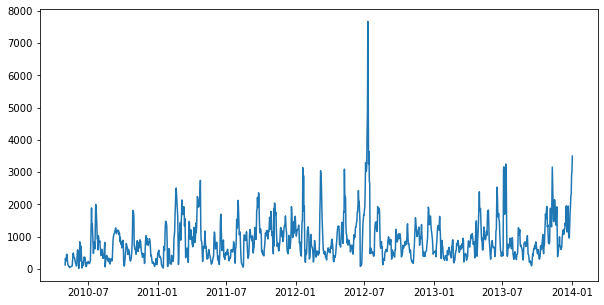

In [8]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df.TOTUSJH);

In [9]:
df = df.values
df = df.astype('float32')

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [11]:
# split into train and test sets
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print(len(train), len(test))

879 434


In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [14]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=5, verbose=2)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

Epoch 1/50
176/176 - 4s - loss: 0.0060 - val_loss: 0.0031
Epoch 2/50
176/176 - 0s - loss: 0.0040 - val_loss: 0.0026
Epoch 3/50
176/176 - 0s - loss: 0.0033 - val_loss: 0.0022
Epoch 4/50
176/176 - 0s - loss: 0.0026 - val_loss: 0.0018
Epoch 5/50
176/176 - 0s - loss: 0.0022 - val_loss: 0.0016
Epoch 6/50
176/176 - 0s - loss: 0.0020 - val_loss: 0.0016
Epoch 7/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 9/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 10/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 11/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0016
Epoch 12/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 13/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0014
Epoch 14/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 15/50
176/176 - 0s - loss: 0.0018 - val_loss: 0.0015
Epoch 16/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 17/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 

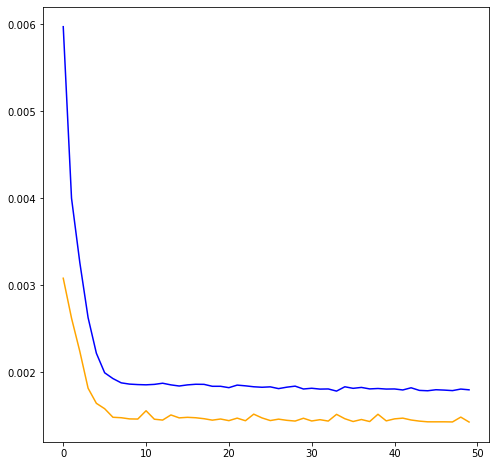

In [16]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(epochs, loss, color='blue')
plt.plot(epochs, val_loss, color='orange')

In [17]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.04 RMSE


In [18]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 321.42 RMSE
Test Score: 289.63 RMSE


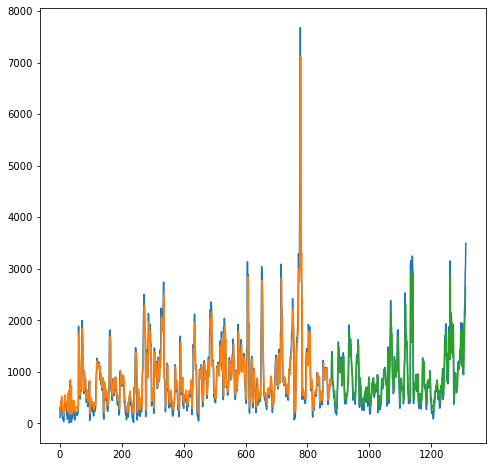

In [19]:
plt.rcParams["figure.figsize"] = (8,8)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Variación 1

#### Cambiar la configuración de la red neuronal de una LSTM normal a Bidireccional y Stacked 

## Bidireccional

In [20]:
from keras.layers import Bidirectional

# load the dataset
df = pd.read_csv('helicity.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.timestamp = df.timestamp.str.split(' ',expand=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.groupby([df['timestamp'].dt.date]).mean()
df = df.values
df = df.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# split into train and test sets
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(Bidirectional(LSTM(4, input_shape=(1, look_back), activation='relu')))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=5, verbose=2)
loss = history.history['loss']
epochs = range(len(loss))

879 434
Epoch 1/50
176/176 - 4s - loss: 0.0079 - val_loss: 0.0040
Epoch 2/50
176/176 - 0s - loss: 0.0054 - val_loss: 0.0035
Epoch 3/50
176/176 - 0s - loss: 0.0045 - val_loss: 0.0029
Epoch 4/50
176/176 - 0s - loss: 0.0036 - val_loss: 0.0024
Epoch 5/50
176/176 - 0s - loss: 0.0029 - val_loss: 0.0020
Epoch 6/50
176/176 - 0s - loss: 0.0023 - val_loss: 0.0017
Epoch 7/50
176/176 - 0s - loss: 0.0020 - val_loss: 0.0016
Epoch 8/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 9/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 10/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 11/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 12/50
176/176 - 0s - loss: 0.0018 - val_loss: 0.0015
Epoch 13/50
176/176 - 0s - loss: 0.0018 - val_loss: 0.0015
Epoch 14/50
176/176 - 0s - loss: 0.0018 - val_loss: 0.0014
Epoch 15/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0014
Epoch 16/50
176/176 - 0s - loss: 0.0018 - val_loss: 0.0015
Epoch 17/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.001

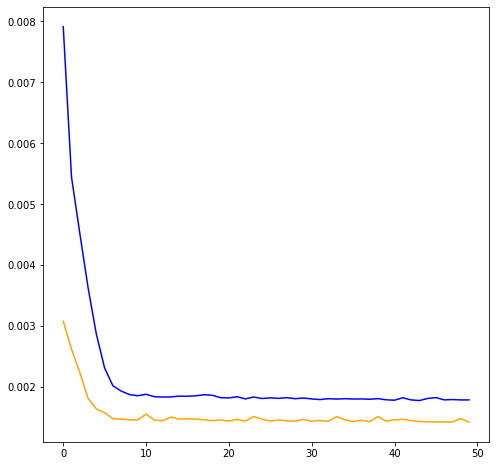

In [21]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(epochs, loss, color='blue')
plt.plot(epochs, val_loss, color='orange')

In [22]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.04 RMSE


In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 321.34 RMSE
Test Score: 290.89 RMSE


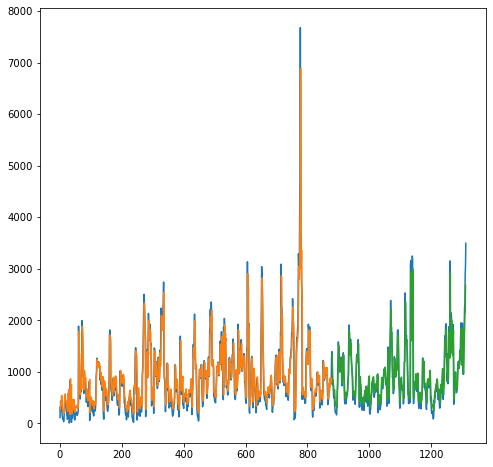

In [24]:
plt.rcParams["figure.figsize"] = (8,8)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Stacked

In [25]:
from keras.layers import Bidirectional

# load the dataset
df = pd.read_csv('helicity.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.timestamp = df.timestamp.str.split(' ',expand=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.groupby([df['timestamp'].dt.date]).mean()
df = df.values
df = df.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# split into train and test sets
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), activation='relu', return_sequences=True,))
model.add(LSTM(4, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=5, verbose=2)
loss = history.history['loss']
epochs = range(len(loss))

879 434
Epoch 1/50
176/176 - 4s - loss: 0.0103 - val_loss: 0.0052
Epoch 2/50
176/176 - 0s - loss: 0.0075 - val_loss: 0.0051
Epoch 3/50
176/176 - 0s - loss: 0.0074 - val_loss: 0.0050
Epoch 4/50
176/176 - 0s - loss: 0.0072 - val_loss: 0.0048
Epoch 5/50
176/176 - 0s - loss: 0.0069 - val_loss: 0.0047
Epoch 6/50
176/176 - 0s - loss: 0.0065 - val_loss: 0.0043
Epoch 7/50
176/176 - 0s - loss: 0.0059 - val_loss: 0.0041
Epoch 8/50
176/176 - 0s - loss: 0.0052 - val_loss: 0.0035
Epoch 9/50
176/176 - 0s - loss: 0.0044 - val_loss: 0.0030
Epoch 10/50
176/176 - 0s - loss: 0.0036 - val_loss: 0.0024
Epoch 11/50
176/176 - 0s - loss: 0.0029 - val_loss: 0.0021
Epoch 12/50
176/176 - 0s - loss: 0.0026 - val_loss: 0.0019
Epoch 13/50
176/176 - 0s - loss: 0.0025 - val_loss: 0.0019
Epoch 14/50
176/176 - 0s - loss: 0.0024 - val_loss: 0.0017
Epoch 15/50
176/176 - 0s - loss: 0.0023 - val_loss: 0.0017
Epoch 16/50
176/176 - 0s - loss: 0.0023 - val_loss: 0.0017
Epoch 17/50
176/176 - 0s - loss: 0.0023 - val_loss: 0.001

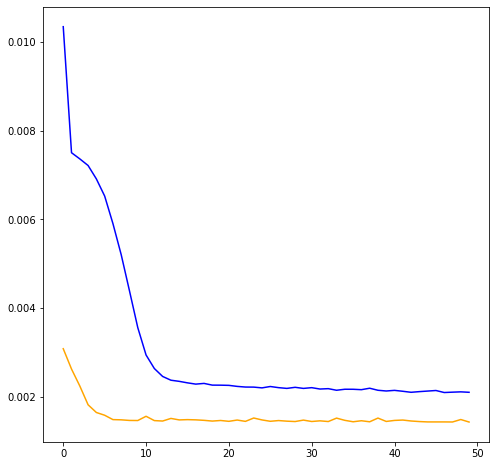

In [26]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(epochs, loss, color='blue')
plt.plot(epochs, val_loss, color='orange')

In [27]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.04 RMSE


In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 349.52 RMSE
Test Score: 302.05 RMSE


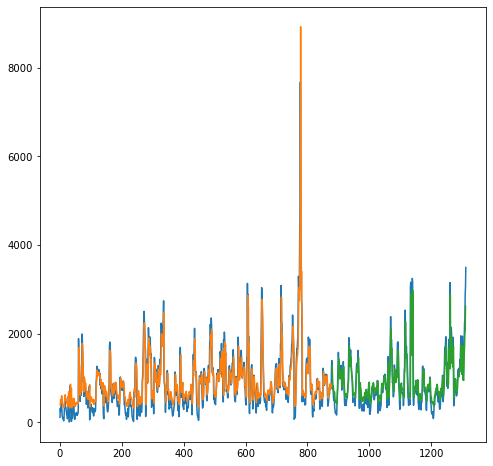

In [29]:
plt.rcParams["figure.figsize"] = (8,8)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Variación 2

#### Una variación del optimizer 

In [40]:
# load the dataset
df = pd.read_csv('helicity.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.timestamp = df.timestamp.str.split(' ',expand=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.groupby([df['timestamp'].dt.date]).mean()
df = df.values
df = df.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# split into train and test sets
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='RMSProp')
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=5, verbose=2)
loss = history.history['loss']
epochs = range(len(loss))

879 434
Epoch 1/50
176/176 - 2s - loss: 0.0088 - val_loss: 0.0046
Epoch 2/50
176/176 - 0s - loss: 0.0065 - val_loss: 0.0043
Epoch 3/50
176/176 - 0s - loss: 0.0061 - val_loss: 0.0040
Epoch 4/50
176/176 - 0s - loss: 0.0055 - val_loss: 0.0036
Epoch 5/50
176/176 - 0s - loss: 0.0049 - val_loss: 0.0032
Epoch 6/50
176/176 - 0s - loss: 0.0042 - val_loss: 0.0030
Epoch 7/50
176/176 - 0s - loss: 0.0035 - val_loss: 0.0024
Epoch 8/50
176/176 - 0s - loss: 0.0029 - val_loss: 0.0020
Epoch 9/50
176/176 - 0s - loss: 0.0025 - val_loss: 0.0018
Epoch 10/50
176/176 - 0s - loss: 0.0021 - val_loss: 0.0016
Epoch 11/50
176/176 - 0s - loss: 0.0020 - val_loss: 0.0015
Epoch 12/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 13/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 14/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 15/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 16/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.0016
Epoch 17/50
176/176 - 0s - loss: 0.0019 - val_loss: 0.001

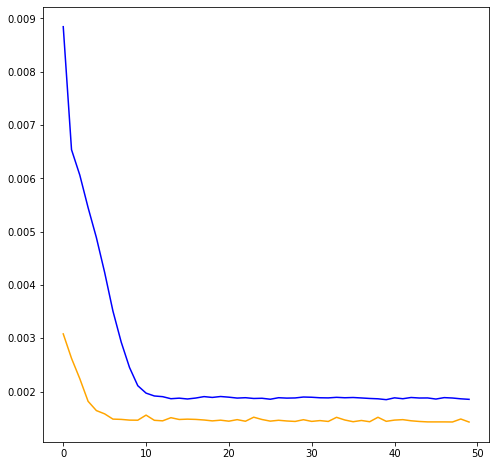

In [41]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(epochs, loss, color='blue')
plt.plot(epochs, val_loss, color='orange')

In [42]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.04 RMSE


In [43]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 332.85 RMSE
Test Score: 294.45 RMSE


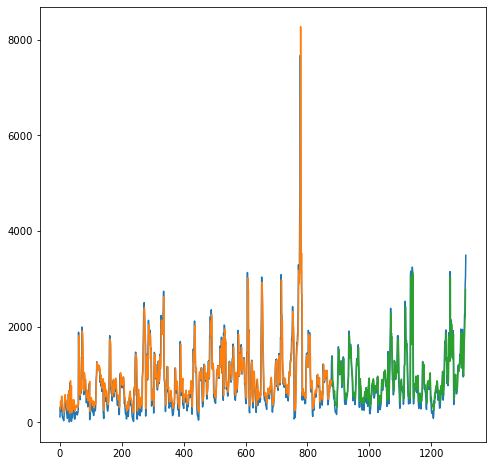

In [44]:
plt.rcParams["figure.figsize"] = (8,8)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Variación 3

#### Cambiar el batch_size (ejemplo de 32 a 64)

In [35]:
# load the dataset
df = pd.read_csv('helicity.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.timestamp = df.timestamp.str.split(' ',expand=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.groupby([df['timestamp'].dt.date]).mean()
df = df.values
df = df.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# split into train and test sets
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=10, verbose=2)
loss = history.history['loss']
epochs = range(len(loss))

879 434
Epoch 1/50
88/88 - 2s - loss: 0.0099 - val_loss: 0.0045
Epoch 2/50
88/88 - 0s - loss: 0.0060 - val_loss: 0.0040
Epoch 3/50
88/88 - 0s - loss: 0.0056 - val_loss: 0.0038
Epoch 4/50
88/88 - 0s - loss: 0.0052 - val_loss: 0.0035
Epoch 5/50
88/88 - 0s - loss: 0.0047 - val_loss: 0.0032
Epoch 6/50
88/88 - 0s - loss: 0.0043 - val_loss: 0.0029
Epoch 7/50
88/88 - 0s - loss: 0.0038 - val_loss: 0.0026
Epoch 8/50
88/88 - 0s - loss: 0.0033 - val_loss: 0.0023
Epoch 9/50
88/88 - 0s - loss: 0.0029 - val_loss: 0.0021
Epoch 10/50
88/88 - 0s - loss: 0.0026 - val_loss: 0.0019
Epoch 11/50
88/88 - 0s - loss: 0.0023 - val_loss: 0.0017
Epoch 12/50
88/88 - 0s - loss: 0.0021 - val_loss: 0.0016
Epoch 13/50
88/88 - 0s - loss: 0.0020 - val_loss: 0.0016
Epoch 14/50
88/88 - 0s - loss: 0.0019 - val_loss: 0.0016
Epoch 15/50
88/88 - 0s - loss: 0.0019 - val_loss: 0.0016
Epoch 16/50
88/88 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 17/50
88/88 - 0s - loss: 0.0019 - val_loss: 0.0015
Epoch 18/50
88/88 - 0s - loss: 0

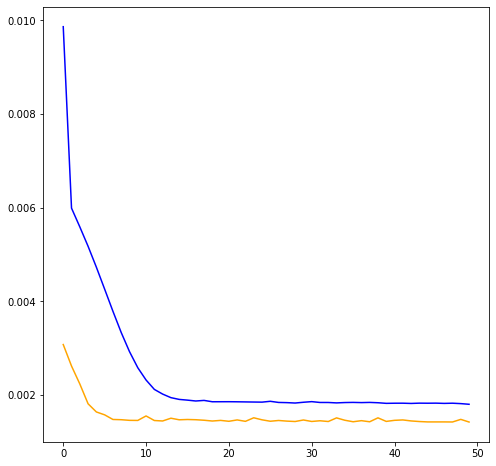

In [36]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(epochs, loss, color='blue')
plt.plot(epochs, val_loss, color='orange')

In [37]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.04 RMSE


In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 326.02 RMSE
Test Score: 293.95 RMSE


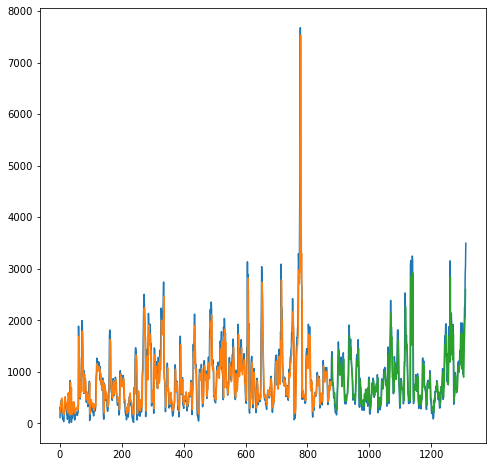

In [39]:
plt.rcParams["figure.figsize"] = (8,8)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()